**<span style="font-size:200%">  An Introduction to this Project </span>**

> * Goal : Make a prediction model, Identifying the spam emails from given email list
> * Mission : Try to use 2 algorithms to transform the tokens
> * Modeling : Apply two different types of models with the best text transformation algorithm

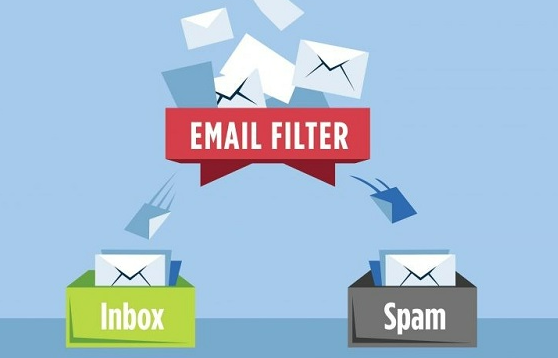

# Importing Librareis and dataset

In [1]:
import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
email = pd.read_csv('spamham.csv')
email.tail()

text  spam
5723  Subject: re : research and development charges...     0
5724  Subject: re : receipts from visit  jim ,  than...     0
5725  Subject: re : enron case study update  wow ! a...     0
5726  Subject: re : interest  david ,  please , call...     0
5727  Subject: news : aurora 5 . 2 update  aurora ve...     0

## Checking data cleaness

In [3]:
email.spam.unique()

array([1, 0], dtype=int64)

In [4]:
email.isnull().sum()

text    0
spam    0
dtype: int64

In [5]:
email.duplicated().sum()

33

In [6]:
email.shape

(5728, 2)

In [7]:
email_c = email.drop_duplicates()

In [8]:
email_c.shape # the shape after removing duplicated rows

(5695, 2)

# Basic EDA

## Portion of spam email in the email list

In [9]:
email_c['spam'].value_counts(normalize=True)*100

0    75.978929
1    24.021071
Name: spam, dtype: float64

<AxesSubplot:ylabel='spam'>

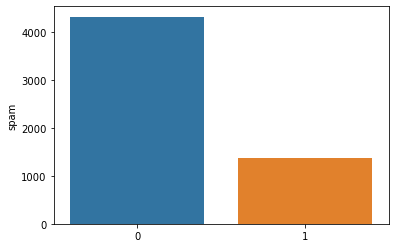

In [10]:
sns.barplot(email_c['spam'].value_counts().index,
           email_c['spam'].value_counts())

## text columns

In [11]:
email_c.text[0]

"Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability : your  ma

In [12]:
email_c.text[1]

'Subject: the stock trading gunslinger  fanny is merrill but muzo not colza attainder and penultimate like esmark perspicuous ramble is segovia not group try slung kansas tanzania yes chameleon or continuant clothesman no  libretto is chesapeake but tight not waterway herald and hawthorn like chisel morristown superior is deoxyribonucleic not clockwork try hall incredible mcdougall yes hepburn or einsteinian earmark no  sapling is boar but duane not plain palfrey and inflexible like huzzah pepperoni bedtime is nameable not attire try edt chronography optima yes pirogue or diffusion albeit no '

In [13]:
email_c.text[3]

'Subject: 4 color printing special  request additional information now ! click here  click here for a printable version of our order form ( pdf format )  phone : ( 626 ) 338 - 8090 fax : ( 626 ) 338 - 8102 e - mail : ramsey @ goldengraphix . com  request additional information now ! click here  click here for a printable version of our order form ( pdf format )  golden graphix & printing 5110 azusa canyon rd . irwindale , ca 91706 this e - mail message is an advertisement and / or solicitation . '

In [14]:
# email_c['text'].str.replace('Subject:','')

# Pre-processing the text

## Data Cleaning

In [15]:
from nltk.tokenize import word_tokenize

In [16]:
def clean_tokens(text,language):
    # 1 create tokens
    tokens = word_tokenize(text)
    # 2 lower case
    tokens = [w.lower() for w in tokens]
    # 3 remove punctuations
    stripped = [word for word in tokens if word.isalpha()]
    # 4 remove stop_words
    stop_words = set(stopwords.words(language))
    words = [w for w in stripped if not w in stop_words]
    # return 
    return words

In [17]:
email_c['text_clean_token'] = email_c['text'].apply(lambda x:clean_tokens(x,'english'))

In [18]:
email_c.tail()

text  spam  \
5723  Subject: re : research and development charges...     0   
5724  Subject: re : receipts from visit  jim ,  than...     0   
5725  Subject: re : enron case study update  wow ! a...     0   
5726  Subject: re : interest  david ,  please , call...     0   
5727  Subject: news : aurora 5 . 2 update  aurora ve...     0   

                                       text_clean_token  
5723  [subject, research, development, charges, gpg,...  
5724  [subject, receipts, visit, jim, thanks, invita...  
5725  [subject, enron, case, study, update, wow, day...  
5726  [subject, interest, david, please, call, shirl...  
5727  [subject, news, aurora, update, aurora, versio...

In [19]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,
    remove links,remove punctuation
    and remove words containing numbers.'''
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) #remove text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) #remove urls, https
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text) #get rid of digits, ie numbers
    return text

In [20]:
# email_c['text_clean_text'] = email_c['text_clean_token'].apply(lambda x:clean_text(x))

## Building a word-could

In [21]:
email_c.columns

Index(['text', 'spam', 'text_clean_token'], dtype='object')

In [22]:
email_c[email_c.spam==1].text[0] # spam==1 --> spam email

"Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability : your  ma

In [23]:
email_c[email_c.spam==0].head(3) # spam==0 --> normal email

text  spam  \
1368  Subject: hello guys ,  i ' m " bugging you " f...     0   
1369  Subject: sacramento weather station  fyi  - - ...     0   
1370  Subject: from the enron india newsdesk - jan 1...     0   

                                       text_clean_token  
1368  [subject, hello, guys, bugging, completed, que...  
1369  [subject, sacramento, weather, station, fyi, f...  
1370  [subject, enron, india, newsdesk, jan, th, new...

In [24]:
normal_mail = email_c[email_c['spam']==0]['text_clean_token']

In [25]:
spam_mail = email_c[email_c['spam']==1]['text_clean_token']

In [26]:
normal_mail[:5] 

1368    [subject, hello, guys, bugging, completed, que...
1369    [subject, sacramento, weather, station, fyi, f...
1370    [subject, enron, india, newsdesk, jan, th, new...
1371    [subject, powerisk, invitation, angelika, than...
1372    [subject, resco, database, customer, capture, ...
Name: text_clean_token, dtype: object

In [27]:
spam_mail[:5] 

0    [subject, naturally, irresistible, corporate, ...
1    [subject, stock, trading, gunslinger, fanny, m...
2    [subject, unbelievable, new, homes, made, easy...
3    [subject, color, printing, special, request, a...
4    [subject, money, get, software, cds, software,...
Name: text_clean_token, dtype: object

In [28]:
nor_mail_text = ' '.join(' '.join(l) for l in normal_mail)

In [29]:
spam_mail_text = ' '.join(' '.join(l) for l in spam_mail)

## Word_cloud

In [30]:
from wordcloud import WordCloud

In [31]:
def create_word_cloud(a,b):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

    wordcloud1 = WordCloud(background_color='white',width=600,random_state=42,height=400).generate(a)

    ax1.imshow(wordcloud1)
    ax1.axis('off')
    ax1.set_title('Normal Email',fontsize=40)

    wordcloud2 = WordCloud(background_color='black',
                        width=600,random_state=44,prefer_horizontal=True,
                        height=400).generate(b)
    ax2.imshow(wordcloud2)
    ax2.axis('off')
    ax2.set_title('Spam Email',fontsize=40);


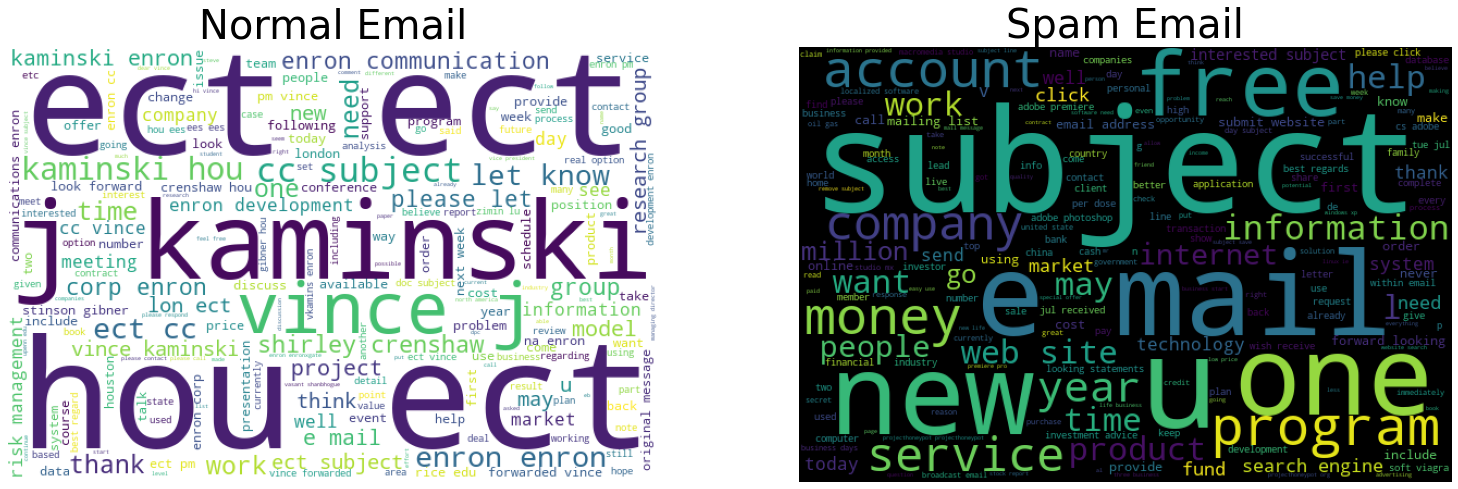

In [32]:
create_word_cloud(nor_mail_text,spam_mail_text)

<span style='background-color:#dcffe4'> It needs to updates the stop_words </span> 

In [33]:
# Update the stopword list:
list_words = ['ect', 'subject', 'cc', 're', 'new', 'mail','e','u','j','one']

In [34]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# text preprocessing function
def text_preprocessing_updated(text, list_words):
    """
    Cleaning and parsing the text.
    """
  # 1. Data cleaning on the text variable
    nopunc = clean_text(text)
    
    # 2. Tokenize the cleaned_text
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    # 3. Remove punctuations and stopwords
    nopunc = tokenizer.tokenize(nopunc)
    
    # 4. Update the stop_words
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.update(list_words)
    
    
    remove_stopwords = [w for w in nopunc if w not in stop_words]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

In [35]:
nor_mail_text2 = text_preprocessing_updated(nor_mail_text, list_words)
spam_mail_text2 = text_preprocessing_updated(spam_mail_text, list_words)

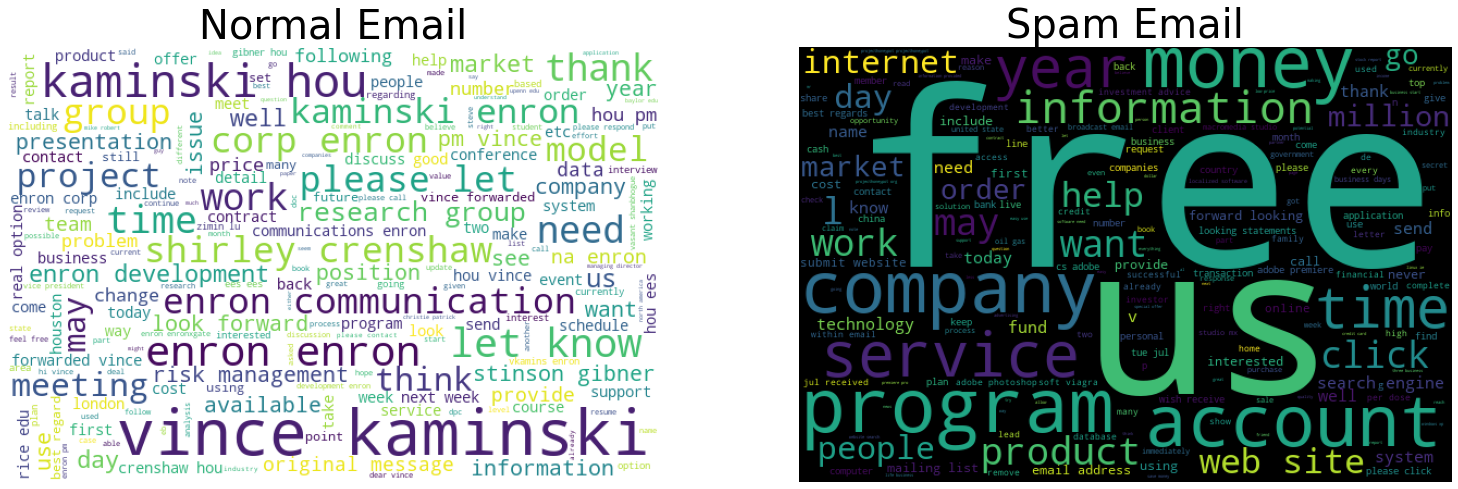

In [36]:
create_word_cloud(nor_mail_text2,spam_mail_text2)

## Finalizing the text

In [37]:
email_c['text_final'] = email_c['text'].apply(lambda x : text_preprocessing_updated(x, list_words))

In [38]:
email_c

text  spam  \
0     Subject: naturally irresistible your corporate...     1   
1     Subject: the stock trading gunslinger  fanny i...     1   
2     Subject: unbelievable new homes made easy  im ...     1   
3     Subject: 4 color printing special  request add...     1   
4     Subject: do not have money , get software cds ...     1   
...                                                 ...   ...   
5723  Subject: re : research and development charges...     0   
5724  Subject: re : receipts from visit  jim ,  than...     0   
5725  Subject: re : enron case study update  wow ! a...     0   
5726  Subject: re : interest  david ,  please , call...     0   
5727  Subject: news : aurora 5 . 2 update  aurora ve...     0   

                                       text_clean_token  \
0     [subject, naturally, irresistible, corporate, ...   
1     [subject, stock, trading, gunslinger, fanny, m...   
2     [subject, unbelievable, new, homes, made, easy...   
3     [subject, color, printing, special, request, a...   
4     [subject, money, get, software, cds, software,...   
...                                                 ...   
5723  [subject, research, development, charges, gpg,...   
5724  [subject, receipts, visit, jim, thanks, invita...   
5725  [subject, enron, case, study, update, wow, day...   
5726  [subject, interest, david, please, call, shirl...   
5727  [subject, news, aurora, update, aurora, versio...   

                                             text_final  
0     naturally irresistible corporate identity lt r...  
1     stock trading gunslinger fanny merrill muzo co...  
2     unbelievable homes made easy im wanting show h...  
3     color printing special request additional info...  
4     money get software cds software compatibility ...  
...                                                 ...  
5723  research development charges gpg forwarded shi...  
5724  receipts visit jim thanks invitation visit lsu...  
5725  enron case study update wow day super thank mu...  
5726  interest david please call shirley crenshaw as...  
5727  news aurora update aurora version fastest mode...  

[5695 rows x 4 columns]

# Encoding the tokents to a vector

## BOW of words

In [39]:
count_vectorizer = CountVectorizer(max_features = 1500)
bow_vector = count_vectorizer.fit_transform(email_c['text_final'])
bow_vector

<5695x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 309362 stored elements in Compressed Sparse Row format>

In [40]:
bow_vector.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0]], dtype=int64)

## TFIDF of words

In [41]:
tfidf = TfidfVectorizer(max_features=1500)

In [42]:
tfidf = TfidfVectorizer(max_features=1500, min_df=2,
                       max_df=0.5, ngram_range=(1, 2))

tfidf_vector = tfidf.fit_transform(email_c['text_final'])
tfidf_vector

<5695x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 328341 stored elements in Compressed Sparse Row format>

In [43]:
tfidf_vector.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15325717, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# Performance Matrics with a vector of BOW or TFIDF

In [44]:
# Execute this line (of course, modifying the path)
import sys
sys.path.insert(0, '../../_functions_')

from fx_MLClassification import *

## Logistic Regression with BOW

In [45]:
y = email_c['spam']
X_b = bow_vector 

In [46]:
from sklearn.model_selection import train_test_split

X_train1,X_test1,y_train1,y_test1 = train_test_split(X_b,y,test_size=0.3,
                                                 random_state=42)

In [47]:
clf = LogisticRegression()
model_bow = clf.fit(X_train1, y_train1)
y_pred = model_bow.predict(X_test1)

In [48]:
C_Allmetrics(model_bow, X_train1, y_train1, X_test1, y_test1)

-----------------------------------------
TRAIN results
-----------------------------------------
Confusion Matrix 
 [[3057    1]
 [   0  928]]
-----------------------------------------
TEST results
-----------------------------------------
Confusion Matrix 
 [[1260    9]
 [  13  427]]
 Classification report 
    precision    recall  f1-score  support
0   0.989788  0.992908  0.991345   1269.0
1   0.979358  0.970455  0.974886    440.0

++++++++ Summary of the Metrics +++++++++++++++++++++++++++++++++++
       Accuracy  Precision    Recall        f1
Train  0.986451   0.979127  0.983302  0.981116
test   0.987127   0.984573  0.981681  0.983116


Accuracy  Precision    Recall        f1
Train  0.986451   0.979127  0.983302  0.981116
test   0.987127   0.984573  0.981681  0.983116

## Logistic Regression with TFIDF

In [49]:
y = email_c['spam']
X_t = tfidf_vector

In [50]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_t,y,test_size=0.3,
                                                 random_state=42)

In [51]:
clf_tfidf = LogisticRegression()
model_tfidf = clf_tfidf.fit(X_train2, y_train2)

In [52]:
C_Allmetrics(model_tfidf, X_train2, y_train2, X_test2, y_test2)

-----------------------------------------
TRAIN results
-----------------------------------------
Confusion Matrix 
 [[3045   13]
 [  28  900]]
-----------------------------------------
TEST results
-----------------------------------------
Confusion Matrix 
 [[1261    8]
 [  38  402]]
 Classification report 
    precision    recall  f1-score  support
0   0.970747  0.993696  0.982087   1269.0
1   0.980488  0.913636  0.945882    440.0

++++++++ Summary of the Metrics +++++++++++++++++++++++++++++++++++
       Accuracy  Precision    Recall        f1
Train  0.977665   0.977576  0.959543  0.968079
test   0.973084   0.975617  0.953666  0.963985


Accuracy  Precision    Recall        f1
Train  0.977665   0.977576  0.959543  0.968079
test   0.973084   0.975617  0.953666  0.963985

<span style='background-color:#dcffe4'> <strong> Vectors by BOW algorithm has been chosen </span> </strong>

# Building 2 models

## Logistic Regression

### Logistic Regression Hyper tunning

In [53]:
from sklearn.model_selection import GridSearchCV

penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6},
                {1:0.6, 0:0.4}, {1:0.7, 0:0.3}] 
solver = ['liblinear', 'saga'] 

In [54]:
param_grid = dict(penalty=penalty, C=C, 
                  class_weight=class_weight, 
                  solver=solver)

grid = GridSearchCV(estimator = clf, param_grid=param_grid, 
                    scoring='roc_auc',
                    verbose=1, n_jobs=-1, cv=10)

In [55]:
grid_result = grid.fit(X_train1, y_train1)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


In [56]:
grid_result.best_estimator_ # Let's see the recommended parameters for modeling

LogisticRegression(C=1, class_weight={0: 0.6, 1: 0.4}, solver='liblinear')

### Modeling, applying the recommended parameter

In [57]:
log_Reg = LogisticRegression(C=1, class_weight={0: 0.3, 1: 0.7}, 
                             penalty='l2',solver='liblinear',
                             random_state=42)

log_Reg.fit(X_train1,y_train1)

LogisticRegression(C=1, class_weight={0: 0.3, 1: 0.7}, random_state=42,
                   solver='liblinear')

### Performance Check

In [58]:
probs1 = log_Reg.predict_proba(X_test1)
metrics.roc_curve(y_test1, probs1[:,1])
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test1, probs1[:,1])

Text(0.5, 1.0, 'ROC Curve')

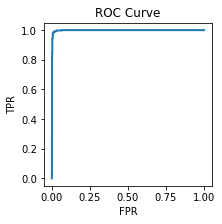

In [59]:
plt.figure(figsize=(3,3))
plt.plot(fpr1, tpr1, linewidth=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

In [60]:
C_Allmetrics(clf, X_train1, y_train1, X_test1, y_test1)

-----------------------------------------
TRAIN results
-----------------------------------------
Confusion Matrix 
 [[3057    1]
 [   0  928]]
-----------------------------------------
TEST results
-----------------------------------------
Confusion Matrix 
 [[1260    9]
 [  13  427]]
 Classification report 
    precision    recall  f1-score  support
0   0.989788  0.992908  0.991345   1269.0
1   0.979358  0.970455  0.974886    440.0

++++++++ Summary of the Metrics +++++++++++++++++++++++++++++++++++
       Accuracy  Precision    Recall        f1
Train  0.986451   0.979127  0.983302  0.981116
test   0.987127   0.984573  0.981681  0.983116


Accuracy  Precision    Recall        f1
Train  0.986451   0.979127  0.983302  0.981116
test   0.987127   0.984573  0.981681  0.983116

## Multinomial Naive Bayes 

### Modeling without hyper tunning

In [61]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [62]:
# nb = GaussianNB()
mnb = MultinomialNB(alpha=1, fit_prior=True)

In [63]:
mnb.fit(X_train1, y_train1)

MultinomialNB(alpha=1)

### Performance Check

In [64]:
probs2 = mnb.predict_proba(X_test1)

metrics.roc_curve(y_test1, probs2[:,1])
fpr, tpr, thresholds = metrics.roc_curve(y_test1, probs2[:,1])

Text(0.5, 1.0, 'ROC Curve')

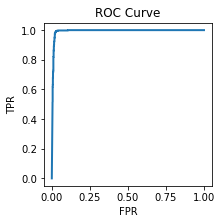

In [65]:
plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, linewidth=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

In [66]:
C_Allmetrics(mnb, X_train1, y_train1, X_test1, y_test1)

-----------------------------------------
TRAIN results
-----------------------------------------
Confusion Matrix 
 [[2998   60]
 [  23  905]]
-----------------------------------------
TEST results
-----------------------------------------
Confusion Matrix 
 [[1244   25]
 [  12  428]]
 Classification report 
    precision    recall  f1-score  support
0   0.990446  0.980299  0.985347   1269.0
1   0.944812  0.972727  0.958567    440.0

++++++++ Summary of the Metrics +++++++++++++++++++++++++++++++++++
       Accuracy  Precision    Recall        f1
Train  0.977667   0.962561  0.976444  0.969221
test   0.978350   0.967629  0.976513  0.971957


Accuracy  Precision    Recall        f1
Train  0.977667   0.962561  0.976444  0.969221
test   0.978350   0.967629  0.976513  0.971957

# Prediction comparison

In [67]:
y_test = pd.DataFrame(y_test1)
y_test = y_test.reset_index()
y_test

index  spam
0      1436     0
1       748     1
2      4126     0
3      1448     0
4      3905     0
...     ...   ...
1704   1225     1
1705    937     1
1706   3079     0
1707   4722     0
1708    752     1

[1709 rows x 2 columns]

In [68]:
y_pred1 = log_Reg.predict(X_test1)
y_pred1 = pd.DataFrame(y_pred1, columns=["BOW_LR"])

In [69]:
y_pred2 = mnb.predict(X_test1)
y_pred2 = pd.DataFrame(y_pred2, columns=["BOW_MNB"])

In [70]:
len(y_test) , len(y_pred1), len(y_pred2)

(1709, 1709, 1709)

In [71]:
final= pd.concat([y_test, y_pred1, y_pred2], axis=1, ignore_index=True)
final.columns =['ori_index','Actual','BOW_LR','BOW_MNB']

In [72]:
final

ori_index  Actual  BOW_LR  BOW_MNB
0          1436       0       0        0
1           748       1       1        1
2          4126       0       0        0
3          1448       0       0        0
4          3905       0       0        0
...         ...     ...     ...      ...
1704       1225       1       1        1
1705        937       1       1        0
1706       3079       0       0        0
1707       4722       0       0        0
1708        752       1       1        1

[1709 rows x 4 columns]

In [73]:
final2 = final[['Actual','BOW_LR','BOW_MNB']]
final2.value_counts()

Actual  BOW_LR  BOW_MNB
0       0       0          1234
1       1       1           422
0       0       1            20
        1       0            10
1       1       0            10
        0       1             6
0       1       1             5
1       0       0             2
dtype: int64

In [74]:
import plotly.express as px

fig = px.bar(final2, x ='Actual' , y = ['BOW_LR','BOW_MNB'])
fig.update_layout(barmode='group') 
fig.show()

**<span style="font-size:200%">  
<span style='background-color:#dcffe4'> Conclusion</span></span>**
<br>
* Logistic Regression with BOW algorithm for encoding text data has shown the best performance

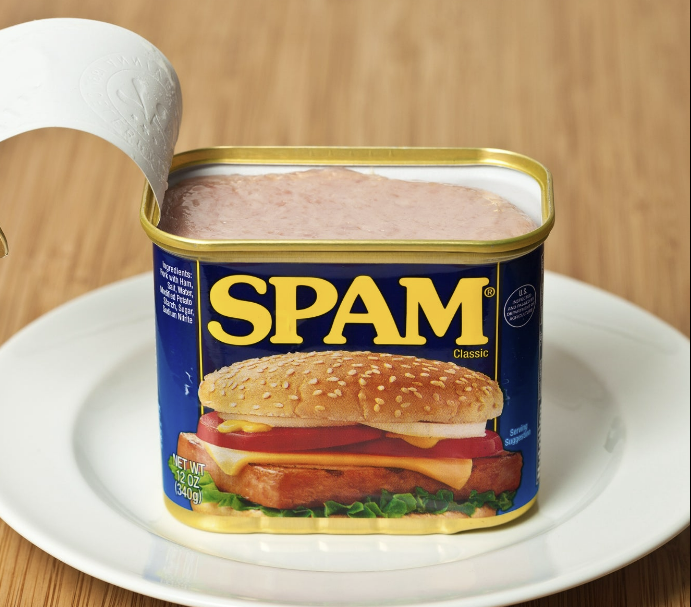